In [40]:
import tensorflow as tf
from deeponet import DeepONet, CosineAnnealingSchedule
from utils import *
import matplotlib.pyplot as plt
import tqdm

In [41]:
device = "/gpu:0" if tf.config.list_physical_devices('GPU') else "/cpu:0"
print("Device :", device)

Device : /gpu:0


In [42]:
model = DeepONet(
    n_branch = 64, 
    n_trunk = 2, 
    width = 20, 
    depth = 3, 
    output_dim = 30,
    activation = "relu", 
)

loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)

lr_schedule = CosineAnnealingSchedule(
    initial_learning_rate=1e-3, 
    decay_steps=50,  
    alpha=0.0 
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


In [43]:
dataloader = DarcyDatasetLoader("DarcyDataset")
train_dataset, test_dataset = dataloader.get_split(test_size = 0.2, batch_size = 128, frac = 0.5)


In [44]:
def downsample(a, u):
    a = tf.expand_dims(a, axis=-1)  
    pooling_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))

    a_downsampled = pooling_layer(a)
    a_downsampled = tf.squeeze(a_downsampled, axis=-1)

    return a_downsampled, u

In [45]:
train_dataset = train_dataset.map(lambda a, u : downsample(a, u))
test_dataset  = test_dataset.map(lambda a, u : downsample(a, u)) 

In [46]:
grid = tf.meshgrid(tf.linspace(0.0, 1.0, 128), tf.linspace(0.0, 1.0, 128))
grid = tf.reshape(tf.stack(grid, axis=-1), (128*128, 2))

print(grid.shape)

(16384, 2)


In [47]:
@tf.function
def train_step(a_batch, u_batch, model, optimizer, loss_fn, grid):
    with tf.GradientTape() as tape:
        predictions = model(a_batch, grid) 
        loss = loss_fn(tf.reshape(u_batch, (-1, 128*128)), predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [ ]:
epochs = 1_000

# Main training loop
for epoch in range(epochs):
    loss_avg = 0.0
    num_batches = 0
    for step, (a_batch, u_batch) in enumerate(train_dataset):
        loss_avg += train_step(a_batch, u_batch, model, optimizer, loss_fn, grid)
        num_batches += 1
    loss_avg /= num_batches

    if (epoch + 1) % 1 == 0:
        tf.print(f"Epoch[{epoch+1}/{epochs}] Loss : {loss_avg.numpy():.9e}", end = '\r')


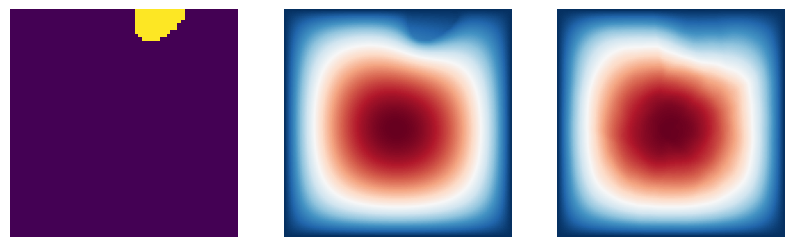

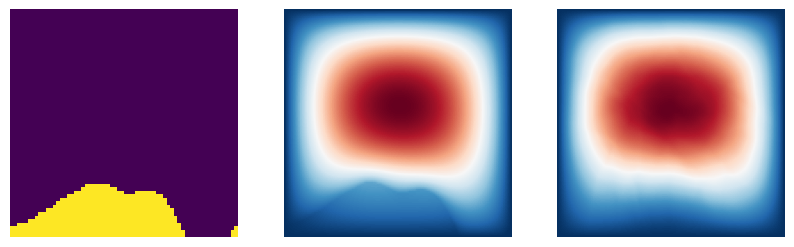

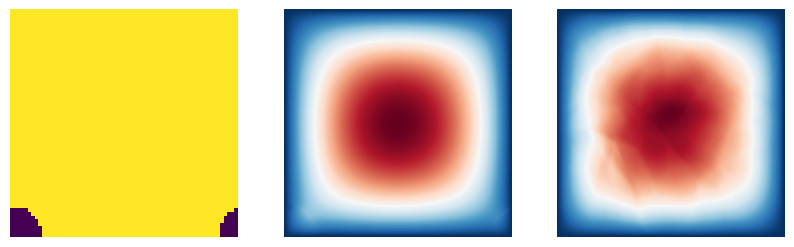

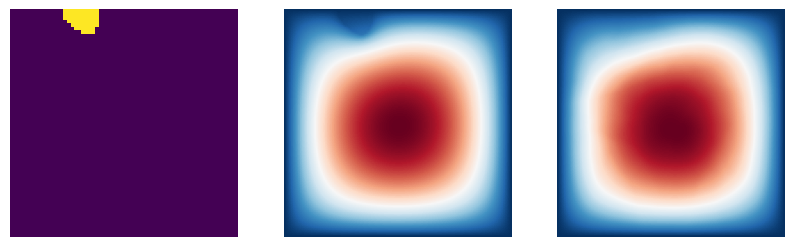

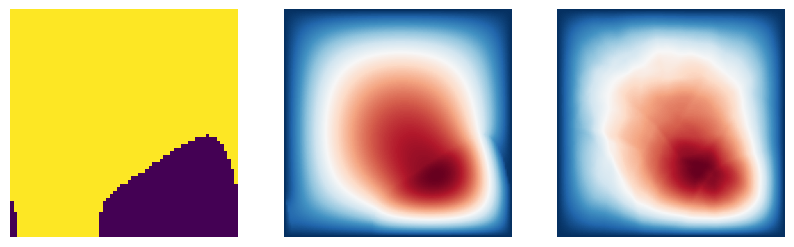

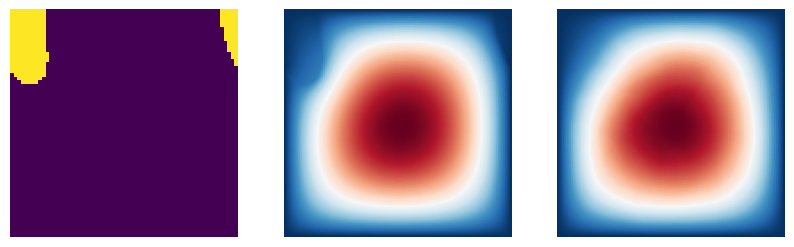

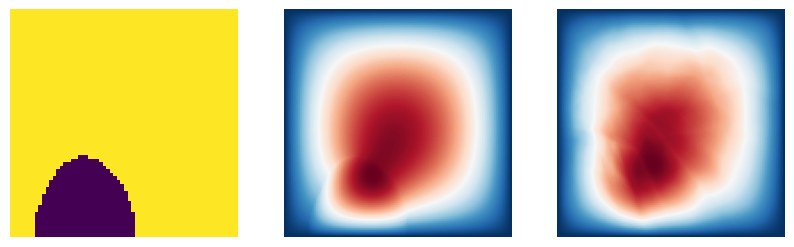

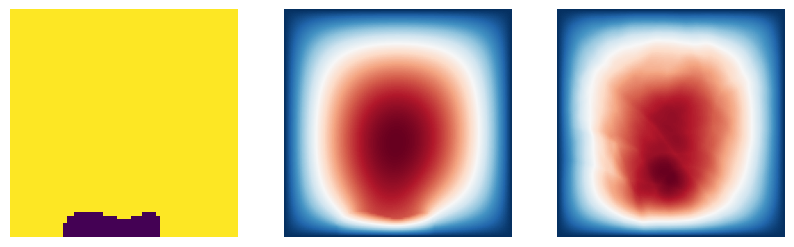

In [ ]:
import matplotlib.pyplot as plt

for a, u in test_dataset.take(10):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    u_pred = model(a, grid)
    u_pred = tf.reshape(u_pred, (-1, 128*128))
    ax[0].imshow(tf.reshape(a[0], (64, 64)), cmap = "viridis")
    ax[0].set_axis_off()
    ax[1].imshow(tf.reshape(u[0], (128, 128)), cmap = "RdBu_r")
    ax[1].set_axis_off()
    ax[2].imshow(tf.reshape(u_pred[0], (128, 128)), cmap = "RdBu_r")
    ax[2].set_axis_off()
    
    plt.show()